# Posterior Distributions of Tourist Locations
## Problem Statement
Analyze and visualize the posterior distributions of locations visited by tourists using Markov Chain Monte Carlo methods.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eig
import random
from tqdm import tqdm

## Load the Dataset

In [2]:
# Define the dataset
data = {
    'Location': ['Museum', 'Concert', 'Sports Event', 'Restaurant', 'Hike'],
    'Museum': [1, 3, 5, 3, 3],
    'Concert': [7, 1, 4, 6, 3],
    'Sports Event': [8, 2, 2, 5, 4],
    'Restaurant': [5, 4, 5, 3, 1],
    'Hike': [2, 4, 1, 5, 1]
}
df = pd.DataFrame(data)
df.set_index('Location', inplace=True)
df['Total'] = df.sum(axis=1)
df.loc['Total'] = df.sum()
df

,Museum,Concert,Sports Event,Restaurant,Hike,Total
Location,,,,,,
Museum,1,7,8,5,2,23
Concert,3,1,2,4,4,14
Sports Event,5,4,2,5,1,17
Restaurant,3,6,5,3,5,22
Hike,3,3,4,1,1,12
Total,15,21,21,18,13,88


## Create Transition Matrix

In [3]:
# Normalize the dataset to create a transition matrix
transition_matrix = df.iloc[:-1, :-1].div(df['Total'][:-1], axis=0)
transition_matrix

,Museum,Concert,Sports Event,Restaurant,Hike
Location,,,,,
Museum,0.043478,0.304348,0.347826,0.217391,0.086957
Concert,0.214286,0.071429,0.142857,0.285714,0.285714
Sports Event,0.294118,0.235294,0.117647,0.294118,0.058824
Restaurant,0.136364,0.272727,0.227273,0.136364,0.227273
Hike,0.250000,0.250000,0.333333,0.083333,0.083333


## Visualize the Markov Chain

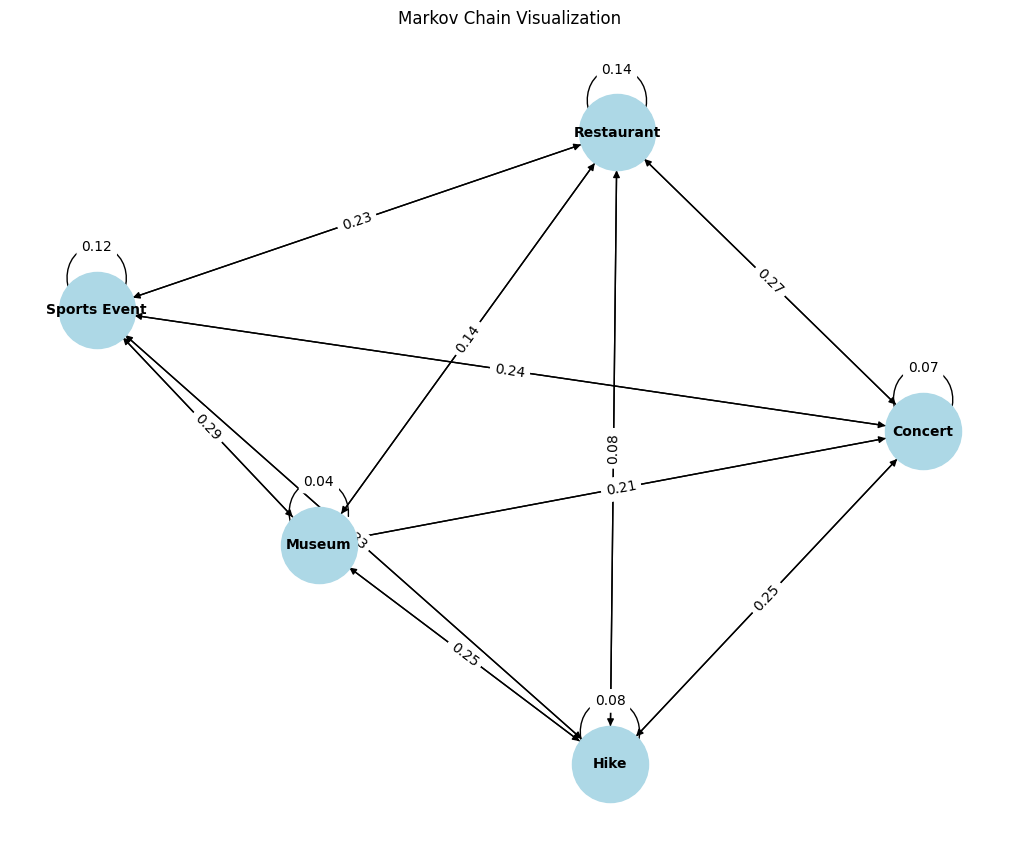

In [4]:
# Create a directed graph to visualize the Markov chain
G = nx.DiGraph()
locations = transition_matrix.index
for i, loc_from in enumerate(locations):
    for j, loc_to in enumerate(locations):
        weight = transition_matrix.iloc[i, j]
        if weight > 0:
            G.add_edge(loc_from, loc_to, weight=weight)

pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
labels = {k: f'{v:.2f}' for k, v in labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Markov Chain Visualization')
plt.show()

## Calculate Steady-State Probabilities

In [5]:
# Calculate steady-state probabilities
P = transition_matrix.values
eigvals, eigvecs = eig(P.T)
steady_state = eigvecs[:, np.isclose(eigvals, 1)]
steady_state = steady_state / steady_state.sum()
steady_state = steady_state.real.flatten()
steady_state

array([0.18883618, 0.22213038, 0.22315604, 0.21187698, 0.15400041])

## Likelihood of Specific Sequences

In [6]:
# Likelihood of attending a concert, then hiking, then dining at a restaurant
sequence = ['Concert', 'Hike', 'Restaurant']
prob = 1
for i in range(len(sequence) - 1):
    prob *= transition_matrix.loc[sequence[i], sequence[i + 1]]
prob

0.023809523809523808

## Fifth Step Probabilities

In [7]:
# Compute the fifth step probabilities
spv = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
fifth_step = np.linalg.matrix_power(P, 5).dot(spv)
fifth_step

array([0.2, 0.2, 0.2, 0.2, 0.2])

## Metropolis-Hastings Algorithm

In [8]:
# Implement Metropolis-Hastings algorithm
def metropolis_hastings(num_samples, initial_alpha, initial_beta):
    samples = []
    alpha, beta = initial_alpha, initial_beta
    for _ in tqdm(range(num_samples)):
        new_alpha = np.random.normal(alpha, 0.5)
        new_beta = np.random.normal(beta, 0.5)
        acceptance_ratio = min(1, np.exp(-(new_alpha**2 + new_beta**2) + (alpha**2 + beta**2)))
        if random.random() < acceptance_ratio:
            alpha, beta = new_alpha, new_beta
        samples.append((alpha, beta))
    return samples

samples = metropolis_hastings(10000, 0, 0)
alphas, betas = zip(*samples)
np.mean(alphas), np.mean(betas)

100%|██████████| 10000/10000 [00:00<00:00, 563864.22it/s]


(-0.04322608738287703, -0.0019911625757562603)

## Interpretation of Results
The results of the Metropolis-Hastings algorithm provide the most likely values for alpha and beta, which can be used to model the tourist's behavior.